In [1]:
import numpy as np
from numpy.testing._private.nosetester import _numpy_tester
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
#import sys
import torch 
#import importlib
import math
import seaborn as sns
import torch.nn as nn


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

filename = 'Regression_Data.txt'
path = "/home/apaulraj/CONUS_GroundWater_Mapping"

#  Variable selection:  
# Choices:
# ['WTD', 'elev', 'PME', 'lnK', 'slope', 'TopoIndex', 'Nrelief', 'Neloc', 'Nefrac', 'Norder', 'Nslope', 'NlnK',
#    'Nvark', 'NPME', 'Rrelief', 'Reloc', 'Refrac', 'Rslope', 'Rlnk', 'Rvark', 'RPME', 'Rarea', 'Rareafrac']
target_name = 'WTD'    # variable to be used as the label
covar_names = ['PME', 'lnK', 'TopoIndex', 'slope'] #variables to use as channels

# Nvark has NaN so excluded for now

output_name = 'mseloss'  # Name to give to the trained model

import Shapes
from Shapes import PFslice2D
import utilities as utilities

cuda:0


(1888, 3342, 23)
(1888, 3342, 23)


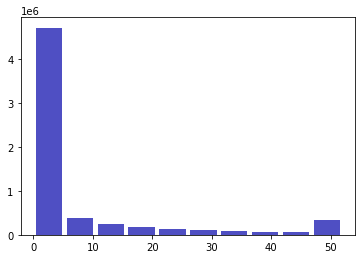

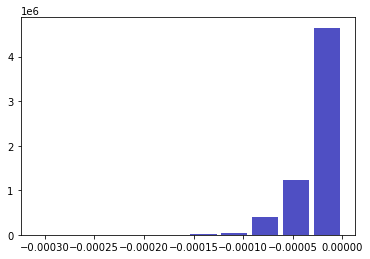

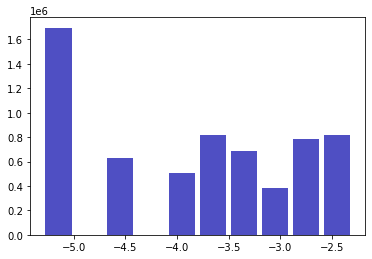

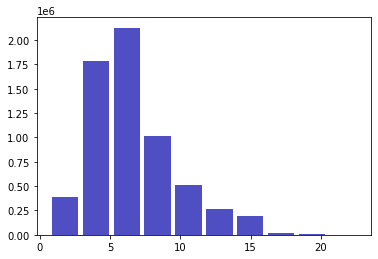

Var, Raw Min, Raw Max, Scaled Min, Scaled Max
WTD 0.0 52.0 0.0 1.0
YOOOOO
elev -82.5 4225.0 0.0 1.0
PME -0.0003113056 0.0 0.0 1.0
lnK -5.29831736654804 -2.30258509299405 0.0 1.0
slope 1e-05 0.5 0.0 1.0
TopoIndex 0.693147180559945 22.6673972621528 0.0 1.0
Nrelief 0.0 3078.5 0.0 1.0
Neloc 0.0 100.647249190939 0.0 1.0
truncating mins
Nefrac 0.0 100.0 0.0 1.0
truncating mins
Norder 0.0 353.0 0.0 1.0
Nslope 0.0 0.298597833333333 0.0 1.0
NlnK -5.29831736654804 0.0 0.0 1.0
Nvark 0.0 2.69232355644389 0.0 1.0
NPME 0.0 2.3324911448495 0.0 1.0
Rrelief 0.0 4291.5 0.0 1.0
Reloc 0.0 743.415077202543 0.0 1.0
truncating mins
Refrac 0.0 743.415077202543 0.0 1.0
truncating mins
Rslope 0.0 0.269042892307692 0.0 1.0
Rlnk -5.29831736654804 0.0 0.0 1.0
Rvark 0.0 1.88094643594086 0.0 1.0
RPME 0.0 2.33249114484951 0.0 1.0
Rarea 0.0 2180870.0 0.0 1.0
Rareafrac 0.0 803.13096123677 0.0 1.0
truncating mins
AFTER SCALING
WTD


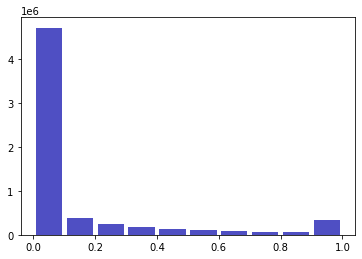

PME


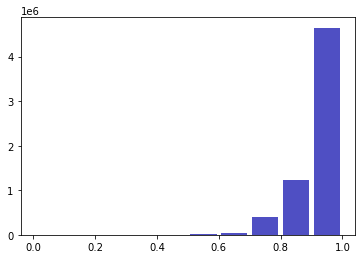

lnK


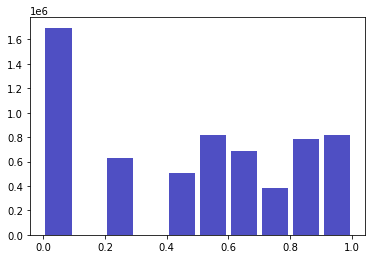

slope


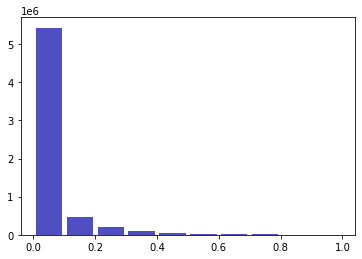

topo


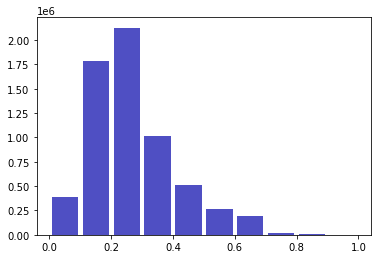

In [2]:
ny = 1888
nx = 3342
ncell = nx*ny
index_list = np.array(list(range(ncell)))
from scipy.stats import zscore
# Read in raw data as pandas data frame
filepath = os.path.join(path, filename)
raw_data = pd.read_table(filepath, sep=',', header=0, index_col=None)
#raw_data = raw_data.apply(zscore)
#print(raw_data['WTD'])

#raw_data['WTD'] = np.sqrt((raw_data['WTD']))
#raw_data['PME'] = np.sqrt((-1*raw_data['PME']))
#print(raw_data[raw_data.isna().any(axis=0)])

#Convert the data into a 3D numpy array with 2D matrices for each column
data_array = np.zeros((ny,nx,raw_data.shape[1]))
ztemp=0
for i in list(raw_data):
    #print(i)
    #raw_data.loc[raw_data[i] == -9999, i] = np.nan #replace -9999's with NAs
    temp=raw_data[i].values
    data_array[:, :, ztemp] = np.flipud(temp.reshape(ny, nx, order='C'))
    ztemp += 1

from scipy import stats
print(data_array.shape)
x_min = 0
x_max = nx #1232
y_min = 0 #1150
y_max = ny
data_array = data_array[y_min:y_max,x_min:x_max,:]
print(data_array.shape)

def normalize_2d(matrix):
    return stats.zscore(matrix, axis=None)


WTD = data_array[:,:,0]
wtdmean = np.mean(WTD)
wtdstd = np.std(WTD)
PME = data_array[:,:,2]
lnK = data_array[:,:,3]
TopoIndex = data_array[:,:,5]

# for i in range(23):
#     data_array[:,:,i] = normalize_2d(data_array[:,:,i])

from matplotlib import pyplot as plt
plt.hist(WTD.ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(PME.ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(lnK.ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

plt.hist(TopoIndex.ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

var_names = list(raw_data)
nvar=len(var_names)
var_summary = pd.DataFrame(data=None, index=var_names)

var_summary['max_raw'] = raw_data.max()
var_summary['min_raw'] = raw_data.min()

var_summary['max_val'] = var_summary['max_raw']
var_summary['min_val'] = var_summary['min_raw']
var_summary.loc[['Reloc', 'Refrac', 'Neloc',
                 'Nefrac', 'Rareafrac'], 'min_val'] = 0.0

var_summary['min_scaled'] = np.zeros(nvar)
var_summary['max_scaled'] = np.ones(nvar)

# NOTE - might want a flag for log options on the scaling

#Scale data
data_scaled = data_array.copy()
data_unscaled = data_array.copy()
ztemp = 0
print("Var, Raw Min, Raw Max, Scaled Min, Scaled Max")
counter = 0
for i in list(raw_data):
    min_r = var_summary.loc[i, 'min_raw']
    max_r = var_summary.loc[i, 'max_raw']
    min_i = var_summary.loc[i, 'min_val']
    max_i = var_summary.loc[i, 'max_val']
    min_f = var_summary.loc[i, 'min_scaled']
    max_f = var_summary.loc[i, 'max_scaled']
    print(i, min_i, max_i, min_f, max_f)

    #adjust any values outside the desired range
    temp=data_array[:,:, ztemp]
    if min_r < min_i:
        print('truncating mins')
        temp[temp<min_i] = min_i

    if max_r > max_i:
        print('truncating maxs')
        temp[temp > max_i] = max_i
    
    if (counter==0):
        counter = counter + 1
        print("YOOOOO")
        wtdmin = min_i
        wtdmax = max_i

    #rescale
    data_scaled[:, :, ztemp] = (temp - min_i)/(max_i-min_i) * (max_f-min_f) + min_f
    #print(i, ztemp, np.min(data_scaled[:, :, ztemp]),
    #      np.max(data_scaled[:, :, ztemp]))
    ztemp += 1

#print(wtdmax)
print("AFTER SCALING")

print("WTD")
plt.hist(data_scaled[:,:,0].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

print("PME")
plt.hist(data_scaled[:,:,2].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

print("lnK")
plt.hist(data_scaled[:,:,3].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

print("slope")
plt.hist(data_scaled[:,:,4].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

print("topo")
plt.hist(data_scaled[:,:,5].ravel(), color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

In [3]:
xs = []
ys = []
patch_width = 50

x_unique = [[] for i in range(x_max-x_min-(patch_width-1))]
#print(x_unique)

run_size = 10000      # total number of clips to take
#nx=2242
for i in range(run_size):
    currentx = np.random.randint(patch_width, x_max-x_min-(patch_width-1))
    xs.append(currentx)  # 0 to nx-(patch_width-1)
    currenty = np.random.randint(0, y_max-y_min-(patch_width-1))
    #print(currentx)
    #print(x_unique[currentx])
    while(currenty in x_unique[currentx]):
        #print("yo")
        currenty = np.random.randint(0, y_max-y_min-(patch_width-1))
    
    ys.append(currenty)
    x_unique[currentx].append(currenty)
    
print(len(xs))
print(len(ys))

# index_max = (x_max-x_min-(patch_width-1))*(y_max-y_min-(patch_width-1))

# # generate indices for lower left corners for clips
# ind_list = set()
# ind_size = 0

# while ind_size < run_size:
#     r = random.randint(0, index_max)
#     if r not in ind_list:
#         ind_size += 1
#         ind_list.add(r)


    
val_start = int(run_size*0.6)
test_start = int(run_size*0.8)
train_x = xs[:val_start]
train_y = ys[:val_start]

# toggle for "ood"/true testing
# val_x = [0 for i in range(y_max-y_min-(patch_width-1))]
# test_x = [0 for i in range(y_max-y_min-(patch_width-1))]
# val_y = [i for i in range(y_max-y_min-(patch_width-1))]
# test_y = [i for i in range(y_max-y_min-(patch_width-1))]

# print(val_x)
# print(test_x)
# print(val_y)
# print(test_y)

val_x = xs[val_start:test_start]
val_y = ys[val_start:test_start]
test_x = xs[test_start:]
test_y = ys[test_start:]


10000
10000


In [4]:
from WTDDataset import MyDataset
from torch.utils.data import DataLoader

target_index = var_names.index(target_name)
covar_index=[var_names.index(x) for x in covar_names]

# Figure out data sizes
nchannel = len(covar_names)
D_in = nchannel * patch_width^2
D_out = patch_width ** 2

test_dataset = MyDataset(data_scaled, test_x, test_y, patch_width, covar_index, target_index)

test_loader = DataLoader(test_dataset, batch_size = 20)


In [5]:


model_path = "/home/apaulraj/SteadyWTD/"

from AndrewCNN import BasicConvNet as ConvNet
#from NN_2D import ConvNet

model = ConvNet(input_channels = 4,
            hidden_channels = 64,
            output_channels = 1,
            kernel_size = 9,
            depth = 11,
            activation = nn.functional.selu)

model2 = ConvNet(input_channels = 4,
            hidden_channels = 64,
            output_channels = 1,
            kernel_size = 9,
            depth = 11,
            activation = nn.functional.selu)
model3 = ConvNet(input_channels = 4,
            hidden_channels = 64,
            output_channels = 1,
            kernel_size = 9,
            depth = 11,
            activation = nn.functional.selu)
model4 = ConvNet(input_channels = 4,
            hidden_channels = 64,
            output_channels = 1,
            kernel_size = 9,
            depth = 11,
            activation = nn.functional.selu)

#model.load_state_dict(torch.load(f"{model_path}justcnn.pt"))
model.load_state_dict(torch.load(f"{model_path}justcnn.pt", map_location=torch.device('cpu')))
model2.load_state_dict(torch.load(f"{model_path}justcnn-copy.pt", map_location=torch.device('cpu')))
model3.load_state_dict(torch.load(f"{model_path}justcnn-clipped.pt", map_location=torch.device('cpu')))
model4.load_state_dict(torch.load(f"{model_path}justcnn-SGD.pt", map_location=torch.device('cpu')))

model.to(DEVICE)
model2.to(DEVICE)
model3.to(DEVICE)
model4.to(DEVICE)

BasicConvNet(
  (layers): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(4, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (4): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (5): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (6): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (7): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (8): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    )
    (9): 

In [6]:
print(wtdmin)
print(wtdmax)

0.0
52.0


wtd max:  52.0
<class 'numpy.ndarray'>
[6.889349   2.474248   0.75445175 ... 0.04015    0.0464     0.0414    ]
None
l1 loss stats
2.3098202
0.5025978
raw diffs stats
-0.021399926
0.0


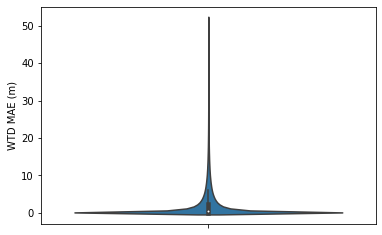

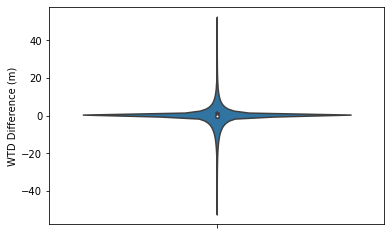

In [7]:
#CORRECTED ANALYSIS (FOR MEDIANS AND SHALLOW STUFF)
import seaborn as sns
print("wtd max: ", wtdmax)
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
from scipy.signal import convolve2d

l1_loss = []
diffs = []
totalshallow = []
counter = 0
for data in test_loader:
    data_in = data[0].float()
    y = data[1].float()
    torch_input = data_in.type(torch.FloatTensor).to(DEVICE)
    torch_label = y.type(torch.FloatTensor).to(DEVICE)
    output = np.squeeze(model(torch_input))
    output = output.reshape((20, patch_width**2))
    torch_label = (torch.mul(torch_label, wtdmax))
    output = (torch.mul(F.relu(output), wtdmax))
    output[output > 52] = 52
    loss = F.smooth_l1_loss(output, torch_label)
    output = np.reshape(output.data.cpu().numpy(), (20, patch_width, patch_width))
    y = np.reshape(torch_label.data.cpu().numpy(), (20, patch_width, patch_width))
    diff = output-y
    local_l1 = np.abs(diff)
    local_l1 = local_l1.flatten()
    l1_loss.append(local_l1.copy())
    diff = diff.flatten()
    diffs.append(diff.copy())
    
    counter = counter + 1

l1_loss = np.array(l1_loss).flatten()
diffs = np.array(diffs).flatten()

print(type(l1_loss))
print(print(l1_loss))
print("l1 loss stats")
print(np.mean(l1_loss))
print(np.median(l1_loss))

print("raw diffs stats")
print(np.mean(diffs))
print(np.median(diffs))

ax = sns.violinplot(y=l1_loss, split=True)
#ax = sns.boxplot(y=l1_loss)
ax.set(ylabel='WTD MAE (m)')
plt.savefig(f'../plots/maeviolin_{output_name}.png', dpi=200)
plt.show()

ax = sns.violinplot(y=diffs)
ax.set(ylabel='WTD Difference (m)')
plt.savefig(f'../plots/diffviolin_{output_name}.png', dpi=200)
plt.show()

# plt.hist(diffs.flatten(), bins=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# plt.show()



yo
l1 loss STATS
mean 1.2499415
median 0.21602356


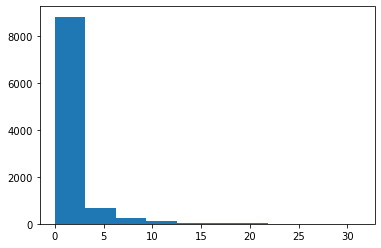

raw diff STATS
mean -0.43878785
median 0.0
std 2.9199014
-32
21


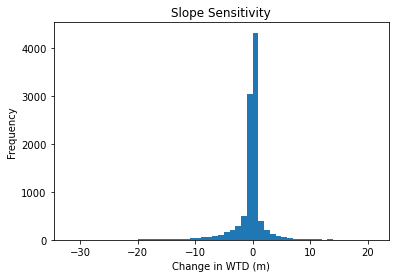

In [13]:
#SENSITIVITY TIME!!!!!
print("yo")
numpoke = 10000
poke_x = xs[0:numpoke]
poke_y = ys[0:numpoke]
poke_dataset = MyDataset(data_scaled, poke_x, poke_y, patch_width, covar_index, target_index)
poke_loader = DataLoader(poke_dataset, batch_size = 1)

l1_diffs = []
raw_diffs = []
counter = 0
# 'PME', 'lnK', 'TopoIndex', 'slope'
poke_name = 'slope'
poke_index = covar_names.index(poke_name)

for data in poke_loader:
    #data = next(iter(poke_loader))
    data_in = data[0].float().numpy().squeeze()
    data_out = data[1].float().numpy().squeeze().reshape(patch_width, patch_width)
    #print(data_out)
#     print(data_in.shape)
#     print(data_out.shape)

    
    noise = np.random.normal(0, 0.1, data_in[poke_index].shape)
#     print(data_in[poke_index].shape)
#     print("ORIGINAL")
#     print(data_in[poke_index])
    noisy_data_in = np.copy(data_in)
    noisy_data_in[poke_index] = data_in[poke_index] + noise
#     print("WITH NOISE")
#     print(noisy_data_in[poke_index])

    clean_output = np.squeeze(model(torch.from_numpy(np.expand_dims(data_in,0)).to(DEVICE)))
    noisy_output = np.squeeze(model(torch.from_numpy(np.expand_dims(noisy_data_in,0)).to(DEVICE)))
    clean_output = np.reshape(clean_output.data.cpu().numpy(), (patch_width,patch_width))
    noisy_output = np.reshape(noisy_output.data.cpu().numpy(), (patch_width,patch_width))
    
    data_out = (torch.mul(torch.from_numpy(data_out), wtdmax)).numpy()
    clean_output = (torch.mul(F.relu(torch.from_numpy(clean_output)), wtdmax)).numpy()
    noisy_output = (torch.mul(F.relu(torch.from_numpy(noisy_output)), wtdmax)).numpy()
    
    raw_diff = clean_output-noisy_output
    random_raw = np.random.choice(raw_diff.flatten())
    raw_diffs.append(random_raw)
    #raw_diffs.append(raw_diff.flatten().copy())
    
    l1_diff = np.abs(raw_diff)
    random_l1 = np.abs(random_raw)
    #print(poke_diff)
    l1_diffs.append(random_l1)
    #l1_diffs.append(l1_diff.copy())
    
#     if(counter%80==0):
#         fig, axs = plt.subplots(1, 3, constrained_layout=True)
#         axs[0].imshow(clean_output, vmin=0,vmax=70)
#         axs[0].set_title('clean output')
#         axs[1].imshow(noisy_output, vmin=0,vmax=70)
#         axs[1].set_title('noisy output')
#         im = axs[2].imshow(data_out, vmin=0,vmax=70)
#         axs[2].set_title('PF output')
#         cbar = plt.colorbar(im,shrink=0.5)
#         #cbar.ax.set_ylabel('WTD (m)', rotation=270)
#         #plt.savefig(f'../plots/noiseplot_{output_name}.png', dpi=200)
#         plt.show()
    counter+=1

l1_diffs = np.array(l1_diffs)
raw_diffs = np.array(raw_diffs)
  
print("l1 loss STATS")
print("mean", np.mean(l1_diffs))
print("median", np.median(l1_diffs))
plt.hist(l1_diffs.flatten())
plt.show()

print("raw diff STATS")
print("mean", np.mean(raw_diffs))
print("median", np.median(raw_diffs))
print("std", np.std(raw_diffs))
data = raw_diffs.copy()
start = int(np.floor(np.min(data)))
print(start)
stop = int(np.ceil(np.max(data)))
print(stop)
plt.hist(data, bins=range(start, stop + 1, 1))
#plt.hist(data)
plt.ylabel("Frequency")
plt.xlabel("Change in WTD (m)")
plt.title("Slope Sensitivity")
plt.savefig(f'../plots/slopehist_1b_{output_name}.png', dpi=200)
plt.show()
